In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import copy

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

In [3]:
# Import RateBeers data
ratebeers_beers_df = pd.read_csv("data/RateBeer/beers.csv")
ratebeers_breweries_df = pd.read_csv("data/RateBeer/breweries.csv")
ratebeers_users_df = pd.read_csv("data/RateBeer/users.csv")

## 1. A quick look at the data

#### Beers

In [4]:
ratebeers_beers_df.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN


We can see that this dataset contains *general information* about the beers : name, id, brewery, style

And some *values* about the beer : # of ratings, overall score, average, etc.

Question: **What is the difference between 'avg', 'avg_computed' and 'overall_score' ?**

In [5]:
ratebeers_beers_df.describe()

,beer_id,brewery_id,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
count,442081.000000,442081.000000,442081.000000,104028.000000,104068.000000,395657.000000,399987.000000,396690.000000,42228.000000,442081.000000,42228.000000
mean,277156.237803,12336.287223,16.110337,55.680817,54.986124,3.026580,6.065485,3.244649,-0.104638,2.308624,3.372042
std,155079.685921,8693.672998,80.988812,28.482652,28.655427,0.304503,1.922965,0.507520,0.732841,26.621223,0.417038
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.500000,-5.460346,0.000000,0.500000
25%,144744.000000,3849.000000,1.000000,34.000000,33.000000,2.870000,4.800000,3.000000,-0.479561,0.000000,3.155129
50%,282812.000000,12457.000000,3.000000,53.000000,51.000000,3.020000,5.600000,3.300000,-0.023696,0.000000,3.409808
75%,411341.000000,18872.000000,9.000000,83.000000,82.000000,3.180000,7.000000,3.594088,0.364636,0.000000,3.650000
max,536489.000000,32246.000000,5272.000000,100.000000,100.000000,4.520000,100.000000,5.000000,2.941123,5270.000000,5.000000


- the **# of ratings** description is interesting : the mean is higher than Q3 because the max is quite high. It seems that a few beers are rated a lot (hundreds/thousands of ratings) whereas most beers only have few ratings (less than 10)
- the **overall score** and **style score** seem close to each other (but there is no value for 3/4 of the data)
- the **avg** is in the range $[0.0, 4.5]$ and **avg_computed** in range $[0.5, 5.0]$ whereas the **abv** is in the range $[0.0, 100.0]$ 

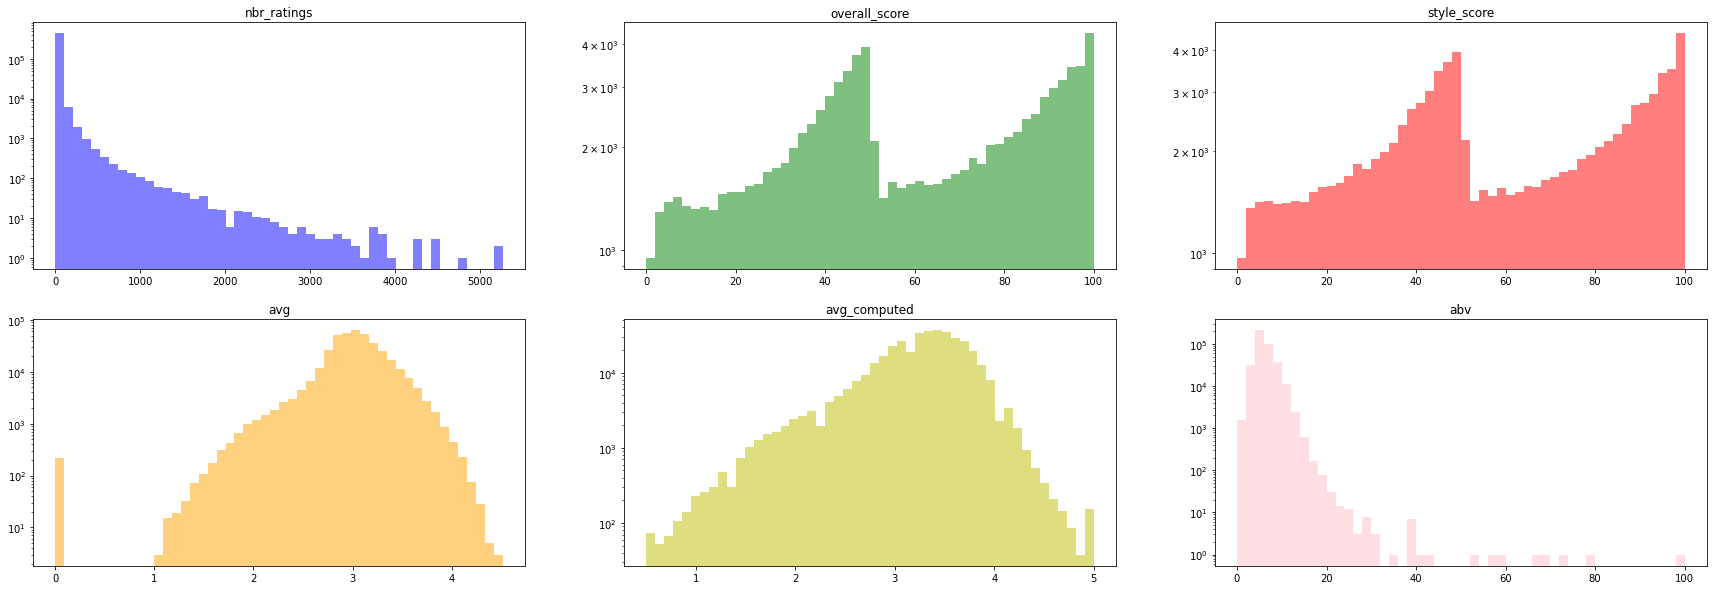

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(30, 10))
features = ['nbr_ratings', 'overall_score', 'style_score', 'avg', 'avg_computed', 'abv']
colors = ['b', 'g', 'r', 'orange', 'y', 'pink']

for i in range(len(features)):
    f = features[i]
    row = i // 3
    col = i % 3
    subplot = axs[row, col]
    
    subplot.hist(ratebeers_beers_df[f], bins=50, alpha=0.5, log=True, color=colors[i])
    subplot.set_title(f)

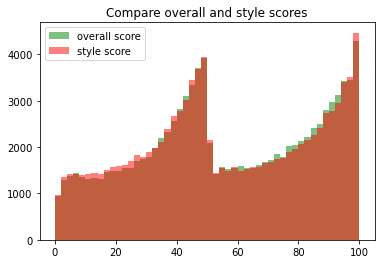

In [19]:
bins = 50
alpha = 0.5

plt.hist(ratebeers_beers_df['overall_score'], bins=bins, alpha=alpha, color='g', label='overall score')
plt.hist(ratebeers_beers_df['style_score'], bins=bins, alpha=alpha, color='r', label='style score')
plt.legend()
plt.title('Compare overall and style scores')
plt.show()

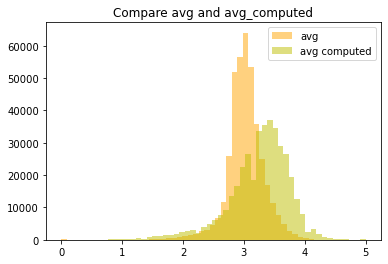

In [20]:
bins = 50
alpha = 0.5

plt.hist(ratebeers_beers_df['avg'], bins=bins, alpha=alpha, color='orange', label='avg')
plt.hist(ratebeers_beers_df['avg_computed'], bins=bins, alpha=alpha, color='y', label='avg computed')
plt.legend()
plt.title('Compare avg and avg_computed')
plt.show()

In [31]:
np.unique(ratebeers_beers_df['style'])

array(['Abbey Dubbel', 'Abbey Tripel', 'Abt/Quadrupel', 'Altbier',
       'Amber Ale', 'Amber Lager/Vienna', 'American Pale Ale',
       'American Strong Ale ', 'Baltic Porter', 'Barley Wine',
       'Belgian Ale', 'Belgian Strong Ale', 'Berliner Weisse', 'Bitter',
       'Bière de Garde', 'Black IPA', 'Brown Ale', 'California Common',
       'Cider', 'Cream Ale', 'Czech Pilsner (Světlý)', 'Doppelbock',
       'Dortmunder/Helles', 'Dry Stout', 'Dunkel/Tmavý', 'Dunkelweizen',
       'Dunkler Bock', 'Eisbock', 'English Pale Ale',
       'English Strong Ale', 'Foreign Stout', 'Fruit Beer',
       'German Hefeweizen', 'German Kristallweizen',
       'Golden Ale/Blond Ale', 'Grodziskie/Gose/Lichtenhainer',
       'Heller Bock', 'Ice Cider/Ice Perry', 'Imperial IPA',
       'Imperial Pils/Strong Pale Lager', 'Imperial Porter',
       'Imperial Stout', 'India Pale Ale (IPA)', 'India Style Lager',
       'Irish Ale', 'Kölsch', 'Lambic Style - Faro',
       'Lambic Style - Fruit', 'Lambic Style

#### Users

In [22]:
ratebeers_users_df.head()

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany


The **joined** feature need to be turned into date

In [27]:
ratebeers_users_df['join_date'] = pd.to_datetime(ratebeers_users_df['joined'], unit='s')

In [29]:
ratebeers_users_df.head()

,nbr_ratings,user_id,user_name,joined,location,join_date
0,1890,175852,Manslow,1.337508e+09,Poland,2012-05-20 10:00:00
1,89,442761,MAGICuenca91,1.484046e+09,Spain,2017-01-10 11:00:00
2,169,288889,Sibarh,1.384600e+09,Poland,2013-11-16 11:00:00
3,3371,250510,fombe89,1.363950e+09,Spain,2013-03-22 11:00:00
4,13043,122778,kevnic2008,1.296644e+09,Germany,2011-02-02 11:00:00


In [30]:
ratebeers_users_df.describe()

,nbr_ratings,user_id,joined
count,70174.000000,70174.000000,7.014400e+04
mean,108.820945,203689.319677,1.306632e+09
std,754.493211,143280.059822,1.300952e+08
min,1.000000,2.000000,9.555336e+08
25%,1.000000,70540.500000,1.204110e+09
50%,2.000000,193917.000000,1.340446e+09
75%,10.000000,327064.000000,1.405850e+09
max,46749.000000,489914.000000,1.501409e+09


Most users rate only a few beers (less than 10) and a few of then rate a lot of beers (up to 46749 beers)

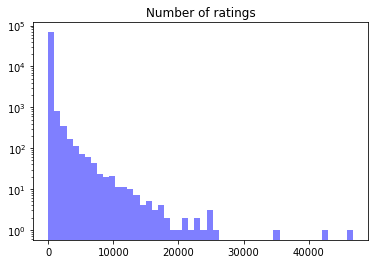

In [34]:
bins = 50
alpha = 0.5

plt.hist(ratebeers_users_df['nbr_ratings'], bins=bins, alpha=alpha, color='blue', log=True)
plt.title('Number of ratings')
plt.show()

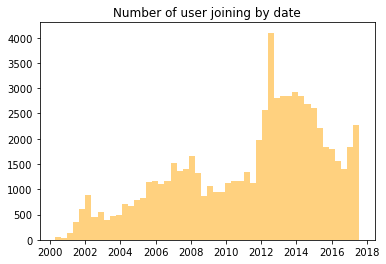

In [35]:
bins = 50
alpha = 0.5

plt.hist(ratebeers_users_df['join_date'], bins=bins, alpha=alpha, color='orange')
plt.title('Number of user joining by date')
plt.show()

In [102]:
countries = ratebeers_users_df['location'].unique()
ratebeers_users_location = ratebeers_users_df.groupby('location')
nbr_users_per_location = ratebeers_users_location.size()
index_interesting_locations = np.where(nbr_users_per_location > 1000)
interesting_locations = nbr_users_per_location.iloc[index_interesting_locations].index

(0.0, 150.0)

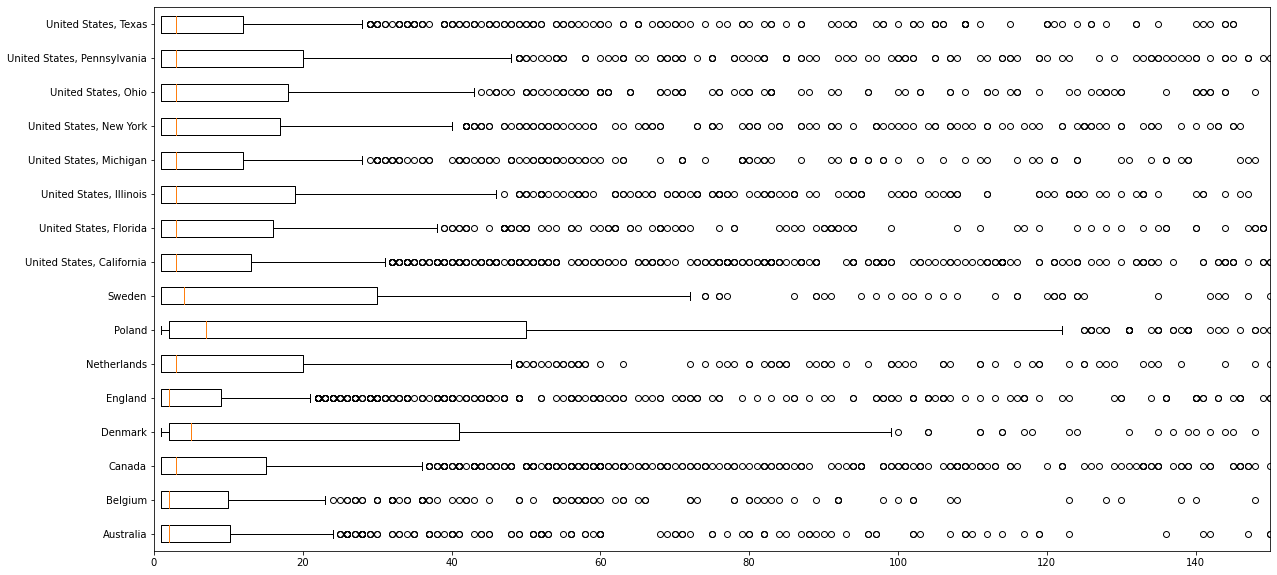

In [137]:
loc = list()
for location in interesting_locations:
    loc.append(ratebeers_users_df[ratebeers_users_df['location'] == location]['nbr_ratings'])


plt.figure(figsize=(20, 10))
plt.boxplot(loc, positions=np.arange(len(interesting_locations)), labels=interesting_locations, vert=False)
plt.xlim(right=150, left=0)

Polish, Danish and Swedish users tend to post more ratings. 

#### Breweries

In [138]:
ratebeers_breweries_df.head()

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


In [139]:
ratebeers_breweries_df.describe()

,id,nbr_beers
count,24189.000000,24189.000000
mean,16639.680061,19.022655
std,9408.751678,31.542620
min,1.000000,0.000000
25%,8746.000000,3.000000
50%,17119.000000,8.000000
75%,24763.000000,20.000000
max,32246.000000,295.000000


Some breweries have zero beers !?

In [140]:
ratebeers_breweries_df[ratebeers_breweries_df['nbr_beers'] == 0]

,id,location,name,nbr_beers
889,17960,Ukraine,TM DeutschHof,0
892,25023,Ukraine,"TORGOVYJ DOM ""SHANDRUK""",0
1098,14044,Canada,La Société Microbrasserie,0
1605,81,Canada,Great Lakes Brewery &#40;Ontario&#41;,0
2055,3547,Japan,Baird Brewing Co.,0
...,...,...,...,...
21637,9678,England,Mallinsons,0
21660,3914,England,Salamander,0
22384,2111,England,Cottage,0
22762,678,Belgium,Brouwerij Van Steenberge,0


In [155]:
nbr_breweries_per_location = ratebeers_breweries_df.groupby('location').size()
index_top_breweries_locations = np.where(nbr_breweries_per_location > 500)
top_breweries_locations = nbr_breweries_per_location.iloc[index_top_breweries_locations]#.index

In [156]:
top_breweries_locations

location
Australia                     550
Canada                        884
England                      2124
France                        843
Germany                      1999
Italy                        1051
Netherlands                   525
Spain                         780
Switzerland                   534
United States, California     867
dtype: int64

In [168]:
index_top_breweries_beers = np.where(ratebeers_breweries_df['nbr_beers'] > 270)
top_breweries_beers = ratebeers_breweries_df.iloc[index_top_breweries_beers]

In [169]:
top_breweries_beers

,id,location,name,nbr_beers
12494,20106,Poland,Browar Wąsosz,295
13644,17792,"United States, California",Cellarmaker Brewing Company,289
13846,340,"United States, California",Karl Strauss Brewing Company,280
14195,480,"United States, California",Triple Rock Brewery & Alehouse,272
14870,14248,"United States, Massachusetts",Night Shift Brewing,291
16961,13326,"United States, Missouri",Perennial Artisan Ales,290
18191,14870,"United States, Florida",Proof Brewing Company,282
18829,343,"United States, Michigan",New Holland Brewing Company,275
19411,489,"United States, Connecticut",Willimantic Brewing Company,283
20942,3911,England,Brodies Beers,279


In [177]:
nbr_styles_per_brewery = list()
for index, brewery in ratebeers_breweries_df.iterrows():
    brewery_id = brewery['id']
    styles = ratebeers_beers_df[ratebeers_beers_df['brewery_id'] == brewery_id]['style'].unique()
    nbr_styles_per_brewery.append(len(styles))

In [180]:
ratebeers_breweries_df['nbr_styles'] = nbr_styles_per_brewery
ratebeers_breweries_df.head()

,id,location,name,nbr_beers,nbr_styles
0,3198,Gabon,Sobraga,3,1
1,13538,Northern Ireland,Ards Brewing Co.,13,7
2,22304,Northern Ireland,Barrahooley Craft Brewery,4,4
3,22818,Northern Ireland,Boundary,66,20
4,24297,Northern Ireland,Brewbot Belfast,3,3


In [182]:
assert(ratebeers_breweries_df['nbr_beers'].all() >= ratebeers_breweries_df['nbr_styles'].all())